In [2]:
import os
import sys
sys.path.append(os.path.expanduser("~/LES-utils/"))
import cmocean
import xarray as xr
import numpy as np
from glob import glob
from LESutils import load_stats
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

# Load some files

In [3]:
basedir = "/home/bgreene/simulations/phiqw/"

sims = ["u0025_tw010_qw016_dq+20_dt+005/output/netcdf"]
        # "u0033_tw02_qw03_dq+20_dt+005/output/netcdf"]

fstat = "mean_stats_xyt_5-6h.nc"
dnc_all = []
sall = []
for sim in sims:
    dnc = f"{basedir}{sim}/"
    dnc_all.append(dnc)
    sall.append(load_stats(dnc+fstat))

Reading file: /home/bgreene/simulations/phiqw/u0025_tw010_qw016_dq+20_dt+005/output/netcdf/mean_stats_xyt_5-6h.nc


Text(0.5, 0, 'Humidity Flux')

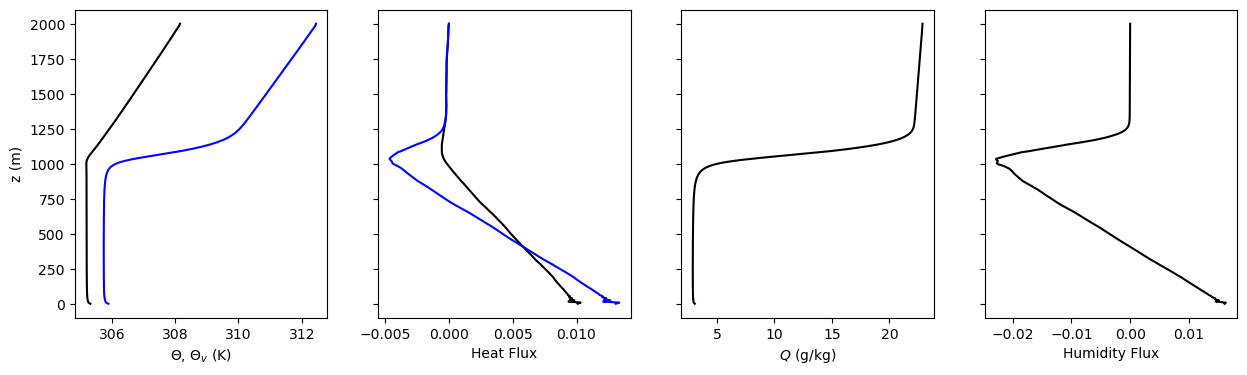

In [4]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(15, 4))

for s in sall:
    ax[0].plot(s.theta_mean, s.z, ls="-", c="k")
    ax[0].plot(s.thetav_mean, s.z, ls="-", c="b")
    ax[1].plot(s.tw_cov_tot, s.z, ls="-", c="k")
    ax[1].plot(s.tvw_cov_tot, s.z, ls="-", c="b")
    ax[2].plot(s.q_mean, s.z, c="k")
    ax[3].plot(s.qw_cov_tot, s.z, c="k")

ax[0].set_ylabel("z (m)")
ax[0].set_xlabel(r"$\Theta$, $\Theta_v$ (K)")
ax[1].set_xlabel("Heat Flux")
ax[2].set_xlabel("$Q$ (g/kg)")
ax[3].set_xlabel("Humidity Flux")

In [5]:
s.delta

23.848213513718214

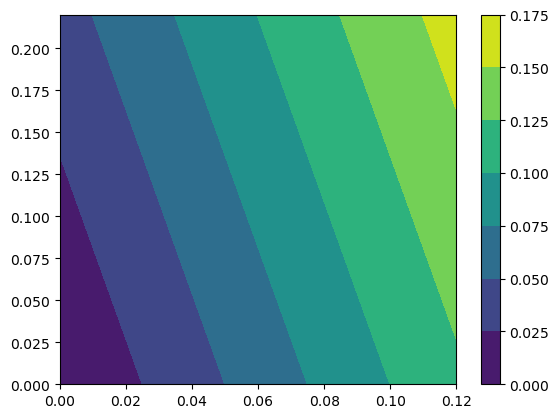

In [39]:
dTdz = np.linspace(0, 0.12, 1000)
dQdz = np.linspace(0, 0.22, 1000)/1000
T0 = 300
Q0 = 2/1000

dTdz2, dQdz2 = np.meshgrid(dTdz, dQdz)

dTvdz = dTdz2*(1+0.61*Q0) + 0.61*T0*dQdz2

plt.contourf(dTdz, dQdz*1000, dTvdz)
plt.colorbar()

In [7]:
d = xr.load_dataset("/home/bgreene/simulations/phiqw/u01_tw12_qw19_dq-20/output/netcdf/all_0540000.nc")

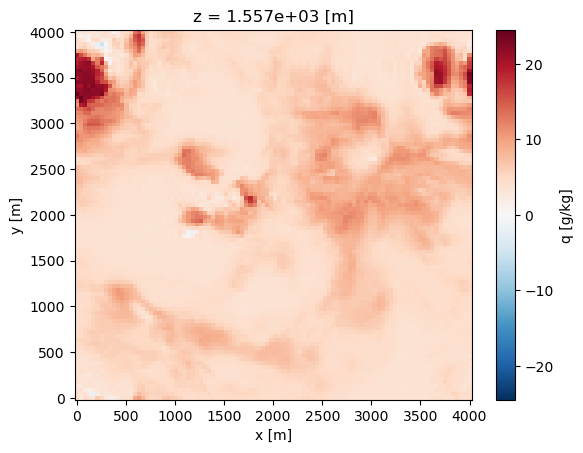

In [12]:
d.q.sel(z=1556, method="nearest").plot(x="x")

In [10]:
for jz in range(256):
    print(d.z[jz].values, d.q.isel(z=jz).min().values.item())

3.90625 18.046533793176007
11.749387254901961 17.88271211440281
19.592524509803923 18.943241249356472
27.43566176470588 18.63515501260688
35.278799019607845 18.632189935074752
43.1219362745098 18.66516852991537
50.96507352941176 18.745629899109375
58.80821078431372 18.731718613044965
66.65134803921569 18.724313224734217
74.49448529411764 18.682172386020373
82.3376225490196 18.676979438159126
90.18075980392156 18.673431141880055
98.02389705882352 18.69825609152073
105.86703431372548 18.64841539274337
113.71017156862744 18.63902591164339
121.5533088235294 18.64627006484437
129.39644607843138 18.658210049197272
137.23958333333331 18.73728397666709
145.08272058823528 18.685333621390456
152.92585784313724 18.63493288483909
160.7689950980392 18.592140827547116
168.61213235294116 18.487801120177902
176.45526960784312 18.42524466443852
184.29840686274508 18.4310910371233
192.14154411764704 18.50869287968687
199.984681372549 18.631003378128675
207.82781862745097 18.737686559836046
215.670955882

In [29]:
for s in sall:
    print(f"--{s.simlabel}--")
    print(f"-zi/L = {-s.h/s.L:.2f}")
    jzi = s.tw_cov_tot.argmin().values
    phi_qw = np.arctan(s.qw_cov_tot[0] / s.qw_cov_tot[jzi]) * 180./np.pi
    print(f"phi_qw = {phi_qw:.1f}")

--u01_tw24_qw10_dq-02--
-zi/L = 984.79
phi_qw = 52.0
--u01_tw24_qw10_dq-02--
-zi/L = 959.74
phi_qw = 54.3


In [7]:
for s in sall:
    print(s.simlabel, s.h.values)

u15_tw10_qw04_dq+06 1047.0435049019607
u15_tw10_qw04_dq+06 1094.1023284313726
u15_tw10_qw04_dq+06 1110.1747047244094


In [1]:
tw = 0.1
qw = 0.146
cp = 1004
Lv = 2.5e6

H = cp*tw
L = Lv*qw/1000

Ef = L / (H + L)
print(Ef)

0.7842715943274603


In [2]:
Ef = 0.8
L = (Ef*H) / (1-Ef)
print(L*1000/Lv)

0.12048000000000005


In [10]:
inst = []
for dnc in dnc_all:
    ff = np.sort(glob(dnc+"all*.nc"))
    print("Loading: ", ff[-1])
    d = xr.load_dataset(ff[-1])
    inst.append(d)

Loading:  /home/bgreene/simulations/test/u01_tw24_qw10_dq-02/output/netcdf/all_0540000.nc


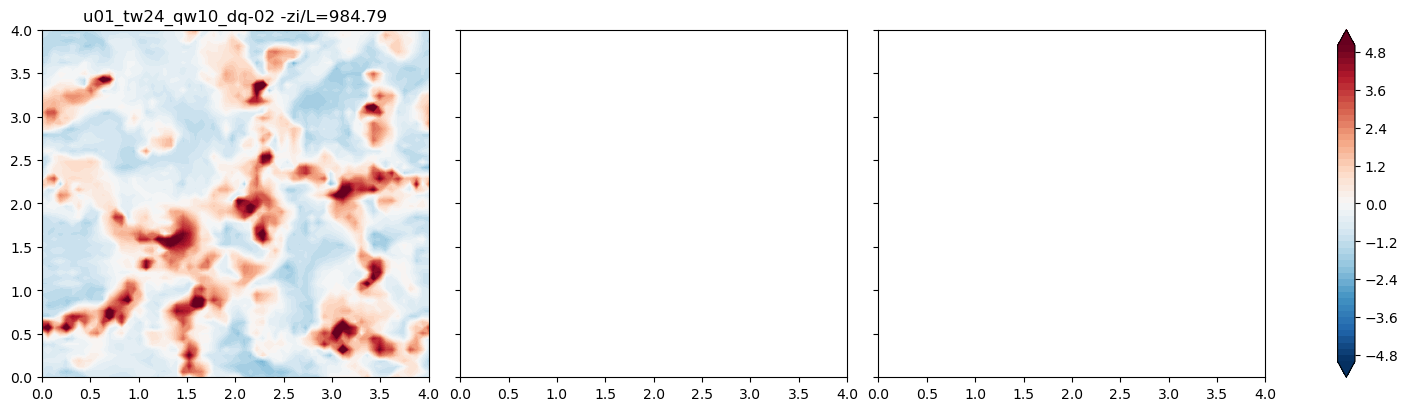

In [11]:
zzi = 0.25

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, 
                       figsize=(14, 4), constrained_layout=True)

for js, (s, d) in enumerate(zip(sall, inst)):
    jz = np.argmin(abs((s.z/s.h).values - zzi))

    cax = ax[js].contourf(d.x/1000, d.y/1000, 
                          (d.theta.isel(z=jz)-d.theta.isel(z=jz).mean()).T/s.Tstar0,
                          levels=np.linspace(-5, 5, 51), extend="both", cmap="RdBu_r")
    ax[js].set_title(f"{s.simlabel} -zi/L={-s.h/s.L:.2f}")

fig.colorbar(cax, ax=ax[:])

In [59]:
for d in inst:
    print(d.q.min().values)

-0.4191500183425878
-0.7919480136433856
3.111617281454232
3.1123299686780754
1.442308849907578


# Look at $\partial z_i / \partial t$

In [14]:
dnc = dnc_all[0]
timesteps = np.arange(450000, 540001, 1000, dtype=int)
fall = [f"{dnc}all_{tt:07d}.nc" for tt in timesteps]
zi = []
for f in fall:
    print(f)
    d = xr.load_dataset(f)
    tw_cov_tot = (xr.cov(d.theta, d.w, dim=("x","y")) + d.tw_sgs.mean(dim=("x","y"))).compute()
    jzmin = tw_cov_tot.argmin()
    zi.append(d.z[jzmin].values)

/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0450000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0451000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0452000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0453000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0454000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0455000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0456000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0457000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0458000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0459000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0460000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0461000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0462000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0463000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_0464000.nc
/home/bgreene/simulations/RFM/u01_tw24_qw10_256/all_046

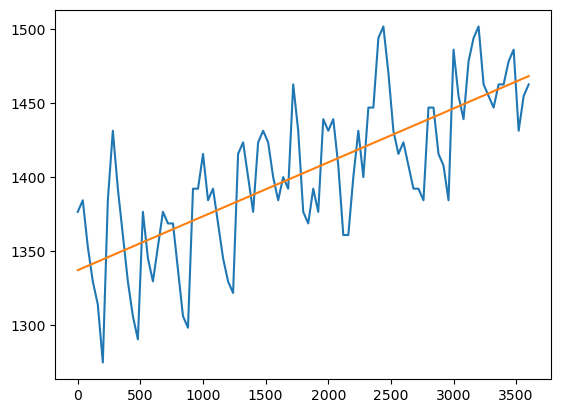

In [21]:
time = 0.04 * (timesteps - timesteps[0])
plt.plot(time, zi)
a, b = np.polyfit(time, zi, 1)
plt.plot(time, a*time + b)

In [23]:
a, b

(0.036486389427565664, 1336.9810183688865)

# Test multiprocessing and pool

In [29]:
from multiprocessing import Pool
from LESutils import out2netcdf
import yaml
from functools import partial

In [6]:
dout = "/home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/"

with open(dout+"params.yaml") as f:
    params = yaml.safe_load(f)

timesteps = np.arange(10000, 30001, 2000, np.int32)

params["del_raw"] = False

dout_all = [dout for _ in range(len(timesteps))]
params_all = [params for _ in range(len(timesteps))]

In [31]:
partial_func = partial(out2netcdf, **params)

pool = Pool()
pool.starmap(partial_func, zip(dout_all, timesteps))

pool.close()
pool.join()

Reading file: /home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/u_0012000.outReading file: /home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/u_0010000.outReading file: /home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/u_0016000.outReading file: /home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/u_0014000.outReading file: /home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/u_0020000.outReading file: /home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/u_0018000.outReading file: /home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/u_0022000.outReading file: /home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/u_0026000.outReading file: /home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/u_0024000.out
Reading file: /home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/u_0028000.out
Reading file: /home/bgreene/simulations/phiqw/u01_tw24_qw10_dq-02/output/u_0030000.out








Reading file: /home/bgreene/simulations/phi